In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
dfps_tr = []
dfps_ts = []
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        if filename.endswith('-training.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_tr.append(dfp)
            print(dfp)
        elif filename.endswith('-testing.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_ts.append(dfp)
            print(dfp)

./dataset\DNS-testing.parquet
./dataset\LDAP-testing.parquet
./dataset\LDAP-training.parquet
./dataset\MSSQL-testing.parquet
./dataset\MSSQL-training.parquet
./dataset\NetBIOS-testing.parquet
./dataset\NetBIOS-training.parquet
./dataset\NTP-testing.parquet
./dataset\Portmap-training.parquet
./dataset\SNMP-testing.parquet
./dataset\Syn-testing.parquet
./dataset\Syn-training.parquet
./dataset\TFTP-testing.parquet
./dataset\UDP-testing.parquet
./dataset\UDP-training.parquet
./dataset\UDPLag-testing.parquet
./dataset\UDPLag-training.parquet


In [4]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

In [5]:
df_train = pd.concat([pd.read_parquet(dfp) for dfp in dfps_tr], ignore_index=True)
df_test = pd.concat([pd.read_parquet(dfp) for dfp in dfps_ts], ignore_index=True)
df_train.shape, df_test.shape

((125170, 78), (306201, 78))

In [6]:
df_train.columns == df_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [7]:
target = 'Label'
print("TRAIN")
print(df_train.Label.value_counts())
print("TEST")
print(df_test.Label.value_counts())

TRAIN
Syn        48840
Benign     46427
UDP        18090
MSSQL       8523
LDAP        1906
Portmap      685
NetBIOS      644
UDPLag        55
Name: Label, dtype: int64
TEST
DrDoS_NTP        121368
TFTP              98917
Benign            51404
DrDoS_UDP         10420
UDP-lag            8872
DrDoS_MSSQL        6212
DrDoS_DNS          3669
DrDoS_SNMP         2717
DrDoS_LDAP         1440
DrDoS_NetBIOS       598
Syn                 533
WebDDoS              51
Name: Label, dtype: int64


## Preprocessing
The Label column typically offers the class and for some classes with multiple attacks it labels them individually.
our first focus is the binary problem so we collapse the class label.

In [8]:
df_train['Label'] = df_train['Label'].astype('object')
df_train.loc[df_train['Label'] != 'Benign', 'Label'] = 1
df_train.loc[df_train['Label'] == 'Benign', 'Label'] = 0
print(df_train['Label'].value_counts())
df_train['Label'] = df_train['Label'].astype(dtype=np.int32)

1    78743
0    46427
Name: Label, dtype: int64


In [9]:
df_test['Label'] = df_test['Label'].astype('object')
df_test.loc[df_test['Label'] != 'Benign', 'Label'] = 1
df_test.loc[df_test['Label'] == 'Benign', 'Label'] = 0
print(df_test['Label'].value_counts())
df_test['Label'] = df_test['Label'].astype(dtype=np.int32)

1    254797
0     51404
Name: Label, dtype: int64


In [10]:
conts = list(df_train.columns.difference([target]).values)
len(conts)

77

In [11]:

from sklearn.utils import shuffle
df_train = shuffle(df_train)
df_test = shuffle(df_test)

In [12]:
#This function is used for separating the dataset into X and y, i.e., separating the label(data) from the dataset(feature).
def xs_y(df_, targ): 
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    y = df_[targ].copy()
    return xs, y

In [14]:
X_train, y_train = xs_y(df_train, targ=target)
X_test, y_test = xs_y(df_test, targ=target)

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.values)
X_test  = scaler.transform(X_test.values)


## Defining the model

In [16]:
 ## input layer 
input_layer = Input(shape=(X_train.shape[1],))

## encoding part
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(48, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

## decoding part
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(48, activation='relu')(decoded)
decoded = Dense(64, activation='relu')(decoded)

## output layer
output_layer = Dense(X_train.shape[1], activation='relu')(decoded)

In [17]:
#Compile the mdoel
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

In [18]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 77)]              0         
                                                                 
 dense (Dense)               (None, 64)                4992      
                                                                 
 dense_1 (Dense)             (None, 48)                3120      
                                                                 
 dense_2 (Dense)             (None, 32)                1568      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 48)                1584  

In [19]:
x_benign = X_train[y_train == 0]

## Training

In [20]:
autoencoder.fit(x_benign, x_benign,
                batch_size = 256, epochs = 50, 
                shuffle = True, validation_split = 0.20);

Epoch 1/50
146/146 [==============================] - 4s 9ms/step - loss: 0.0206 - val_loss: 0.0038
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/50
146/146 [==============================] - 1s 4ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/50
146/146 [==============================] - 1s 4ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/50
146/146 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/50
146/146 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0015

In [21]:
#getting latent learnt representation by autoencoder (used it to make it easier for logistic rrgression to understand the data)
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [22]:
X_train_rep = hidden_representation.predict(X_train)

3912/3912 [==============================] - 8s 2ms/step


## Plotting the hidden representation -tSNE plot

C:\Users\Admin\AppData\Local\Temp\ipykernel_11824\1836729930.py:28: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tsne_plot(X_train_rep[:8000], y_train[:8000])


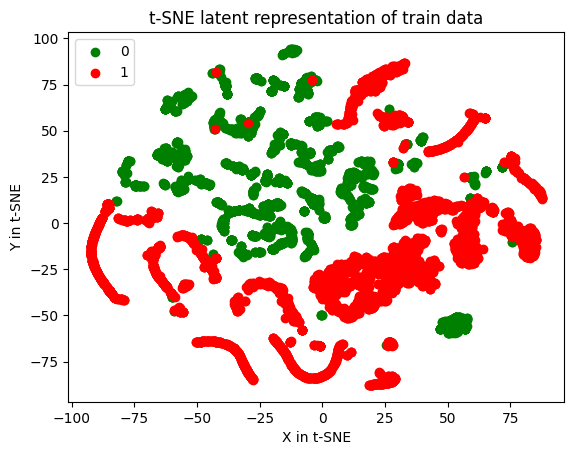

In [23]:
def tsne_plot(x1, y1, name="graph1.png"):
    
    #Scale features to improve the training ability of TSNE.
    standard_scaler = preprocessing.StandardScaler()
    df2_std = standard_scaler.fit_transform(x1)

    tsne = TSNE(n_components=2, random_state=0)
    x_test_2d = tsne.fit_transform(df2_std)
    
    #Build the scatter plot with the two types of transactions.
    color_map = {0:'green', 1:'red'}
    plt.figure()
    for idx, cl in enumerate(np.unique(y_train)):
        plt.scatter(x = x_test_2d[y1==cl,0], 
                    y = x_test_2d[y1==cl,1], 
                    c = color_map[idx], 
                    label = cl)
    plt.xlabel('X in t-SNE')
    plt.ylabel('Y in t-SNE')
    plt.legend(loc='upper left')
    plt.title('t-SNE latent representation of train data')
    plt.savefig(name)
    plt.show()




tsne_plot(X_train_rep[:8000], y_train[:8000])

C:\Users\Admin\AppData\Local\Temp\ipykernel_11824\1707162261.py:28: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tsne_plot(X_train[:8000], y_train[:8000])


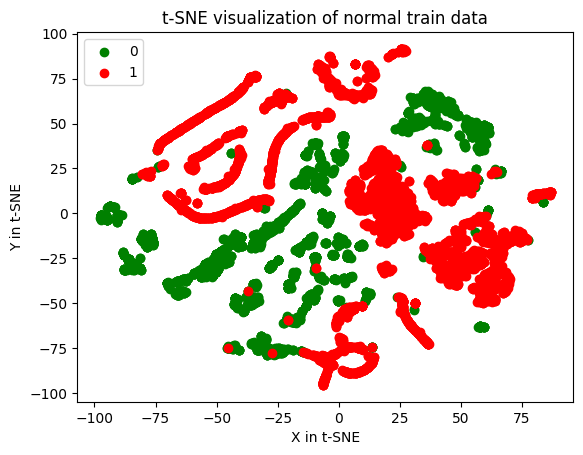

In [24]:
def tsne_plot(x1, y1, name="graph2.png"):
    
    #Scale features to improve the training ability of TSNE.
    standard_scaler = preprocessing.StandardScaler()
    df2_std = standard_scaler.fit_transform(x1)

    tsne = TSNE(n_components=2, random_state=0)
    x_test_2d = tsne.fit_transform(df2_std)
    
    #Build the scatter plot with the two types of transactions.
    color_map = {0:'green', 1:'red'}
    plt.figure()
    for idx, cl in enumerate(np.unique(y_train)):
        plt.scatter(x = x_test_2d[y1==cl,0], 
                    y = x_test_2d[y1==cl,1], 
                    c = color_map[idx], 
                    label = cl)
    plt.xlabel('X in t-SNE')
    plt.ylabel('Y in t-SNE')
    plt.legend(loc='upper left')
    plt.title('t-SNE visualization of normal train data')
    plt.savefig(name)
    plt.show()




tsne_plot(X_train[:8000], y_train[:8000])

# Evaluation

## Train Set

In [25]:
# Training a Logistic Regression classifier on learnt representations

clf = LogisticRegression(max_iter=500).fit(X_train_rep, y_train)
pred_y = clf.predict(X_train_rep)

print ("")
print ("Classification Report: ")
print (classification_report(y_train, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(y_train, pred_y))


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     46427
           1       0.99      1.00      0.99     78743

    accuracy                           0.99    125170
   macro avg       0.99      0.99      0.99    125170
weighted avg       0.99      0.99      0.99    125170


Accuracy Score:  0.9879683630262842


## Test Set

In [26]:
# Getting the test set latent representation
X_test_rep = hidden_representation.predict(X_test)

9569/9569 [==============================] - 11s 1ms/step


In [27]:
pred_y = clf.predict(X_test_rep)

print ("")
print ("Classification Report: ")
print (classification_report(pred_y, y_test))

print ("")
print ("Accuracy Score: ", accuracy_score(pred_y, y_test))


Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     51671
           1       0.99      1.00      1.00    254530

    accuracy                           0.99    306201
   macro avg       0.99      0.98      0.99    306201
weighted avg       0.99      0.99      0.99    306201


Accuracy Score:  0.9919366690507215


## Confusion Matrix

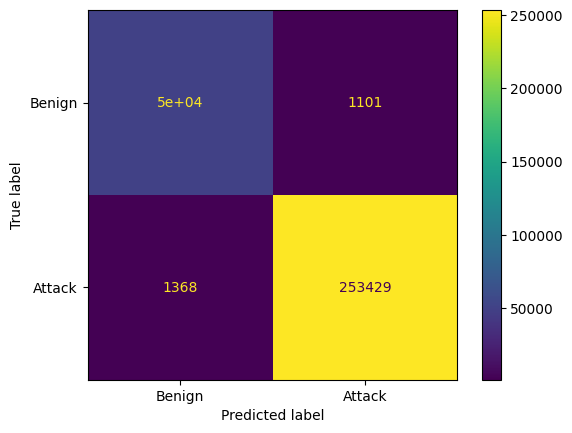

In [28]:
import sklearn
cm = sklearn.metrics.confusion_matrix(y_test, pred_y)
disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=["Benign", "Attack"])
disp.plot()
plt.show()

## ROC Curve

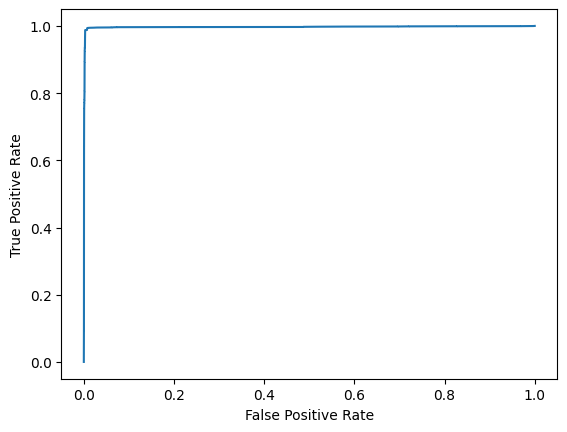

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

y_score = clf.predict_proba(X_test_rep)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1]) 
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()